In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

df_prescribers = pd.read_csv("pa2017.csv", dtype={'NPI': str})  # 1 row per dr
df_drugs = pd.read_csv("padrugs2017.csv", dtype={'NPI': str})  # 1 row per dr/drug
df_opioids = pd.read_csv("druggeographypa.csv", dtype={'Gnrc_Name': str})  # classify

df_drugs = df_drugs.merge(df_opioids, on="Gnrc_Name", how="left")  # Add opioid classification to drug data
df_opioids_only = df_drugs[df_drugs["Opioid_Drug_Flag"] == 'Y']  # Keep only opioid drugs

In [2]:
codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")
print(codes.columns)
df_opioids = codes[codes["pharmclas"].str.contains("opioid agonist", case=False, na=False)]
opioid_ndcs = df_opioids[["ndc"]].drop_duplicates()
opioid_ndcs.to_csv("opioid_ndcs.csv", index=False)
print("Opioid NDCs extracted and saved as 'opioid_ndcs.csv'")

Index(['prodid', 'ndc', 'prodtype', 'propname', 'propsuf', 'npropname',
       'dosename', 'routename', 'stmarkdatestr', 'stmarkdate',
       'endmarkdatestr', 'endmarkdate', 'markname', 'appnum', 'labelname',
       'subname', 'actnumstr', 'actingunit', 'pharmclas', 'deasched',
       'ndc_exclude_flag', 'listing_record_certstr', 'listing_record_cert'],
      dtype='object')
Opioid NDCs extracted and saved as 'opioid_ndcs.csv'


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1712877063.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")


In [3]:
df_opioids_agg = df_opioids_only.groupby("Prscrbr_NPI").agg(
    Total_Opioid_Claims=("Tot_Clms_x", "sum"),  # Total opioid prescriptions per doctor
    Unique_Opioid_Drugs=("Gnrc_Name", "nunique")  # Number of distinct opioids prescribed
).reset_index()

df_merged = pd.merge(df_prescribers, df_opioids_agg, on="Prscrbr_NPI", how="left")
df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
df_merged["Unique_Opioid_Drugs"].fillna(0, inplace=True)

df_specialty_stats = df_merged.groupby("Prscrbr_Type")["Total_Opioid_Claims"].agg(['mean', 'std']).reset_index()
df_specialty_stats.rename(columns={'mean': 'Specialty_Mean_Opioid_Claims', 'std': 'Specialty_Std_Opioid_Claims'}, inplace=True)

df_merged = pd.merge(df_merged, df_specialty_stats, on="Prscrbr_Type", how="left")

df_merged["Opioid_Prescribing_ZScore"] = (df_merged["Total_Opioid_Claims"] - df_merged["Specialty_Mean_Opioid_Claims"]) / df_merged["Specialty_Std_Opioid_Claims"]
df_merged.to_csv("pa_merged_opioid_specialty_adjusted.csv", index=False)


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1131647889.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1131647889.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [235]:
df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str}) 
df_opioid_ndcs = pd.read_csv("opioid_ndcs.csv", dtype=str)
opioid_ndc_set = set(df_opioid_ndcs["ndc"].astype(str).str.strip())
def is_opioid_payment(row):
    for i in range(1, 6):  
        ndc = str(row.get(f"Associated_Drug_or_Biological_NDC_{i}", "")) 
        if any(opioid_ndc in ndc for opioid_ndc in opioid_ndc_set):  
            return True
    return False
df_payments["Is_Opioid_Payment"] = df_payments.apply(is_opioid_payment, axis=1)
df_opioid_payments = df_payments[df_payments["Is_Opioid_Payment"]]
df_opioid_payments.to_csv("opioid_payments_filtered.csv", index=False)
print("Filtered Open Payments data saved as 'opioid_payments_filtered.csv'")

/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/2791430706.py:1: DtypeWarning: Columns (4,10,15,32,33,34,35,51,53,54,69,75,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str})


Filtered Open Payments data saved as 'opioid_payments_filtered.csv'


In [236]:
df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})
df_network = df_opioid_payments.groupby(["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Covered_Recipient_NPI"]).agg(
    Total_Opioid_Payments=("Total_Amount_of_Payment_USDollars", "sum")
).reset_index()
df_network.to_csv("pharma_prescriber_network_data.csv", index=False)
print("Aggregated network data saved as 'pharma_prescriber_network_data.csv'")

Aggregated network data saved as 'pharma_prescriber_network_data.csv'


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/171572685.py:1: DtypeWarning: Columns (4,35,51,54,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})


In [237]:
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={'covered_recipient_NPI': str})
G = nx.DiGraph()
pharma_nodes = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
prescriber_nodes = df_network["Covered_Recipient_NPI"].unique()
G.add_nodes_from(pharma_nodes, bipartite=0)  # Group 0: Pharma companies
G.add_nodes_from(prescriber_nodes, bipartite=1)  # Group 1: Prescribers
for _, row in df_network.iterrows():
    G.add_edge(row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"], 
               row["Covered_Recipient_NPI"], 
               weight=row["Total_Opioid_Payments"])
nx.write_gml(G, "pharma_prescriber_network.gml")
print("Network constructed and saved as 'pharma_prescriber_network.gml'")

Network constructed and saved as 'pharma_prescriber_network.gml'


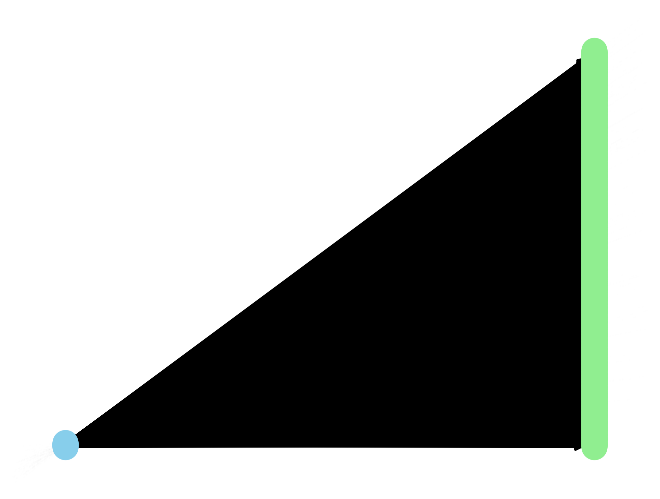

Total pharmaceutical companies: 24
Total doctors: 2026


In [238]:
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

left_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
right_nodes = set(G) - left_nodes
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(left_nodes))
pos.update((n, (2, i)) for i, n in enumerate(right_nodes))
nx.draw(G, pos, with_labels=False, node_color=['skyblue' if n in left_nodes else 'lightgreen' for n in G.nodes()])
plt.show()

pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}

print(f"Total pharmaceutical companies: {len(pharma_nodes)}")
print(f"Total doctors: {len(doctor_nodes)}")

In [247]:
pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
centrality = bipartite.degree_centrality(G, pharma_nodes)
pharma_centrality = {n: c for n, c in centrality.items() if n in pharma_nodes}
for node, centrality_score in pharma_centrality.items():
    print(f"{node}: {centrality_score:.4f}")
unweighted_degree = dict(G.degree(pharma_nodes))
for node in pharma_nodes:
    print(f"{node}: {unweighted_degree[node]:,.2f}")

Mallinckrodt LLC: 0.0010
INSYS Therapeutics Inc: 0.0997
The Medicines Company: 0.0138
Daiichi Sankyo Inc.: 0.1037
Collegium Pharmaceutical, Inc.: 0.1422
BioDelivery Sciences International, Inc.: 0.0647
Mylan Institutional Inc.: 0.0039
Egalet US Inc: 0.0582
Purdue Pharma L.P.: 0.4768
Akrimax Pharmaceuticals, LLC: 0.0064
Pernix Therapeutics Holdings, Inc.: 0.1022
Purdue Transdermal Technologies L.P.: 0.0005
Endo Pharmaceuticals Inc.: 0.0015
PFIZER INC.: 0.0933
Mission Pharmacal Company: 0.0104
Indivior Inc.: 0.1624
Depomed, Inc.: 0.2878
Orexo US, Inc.: 0.0582
Mylan Specialty L.P.: 0.0227
Braeburn Pharmaceuticals, Inc.: 0.0395
Vertical Pharmaceuticals, LLC: 0.0370
Fresenius Kabi USA, LLC: 0.0005
Mylan Pharmaceuticals Inc.: 0.0123
Sentynl Therapeutics, Inc.: 0.0311
Mallinckrodt LLC: 2.00
The Medicines Company: 28.00
Daiichi Sankyo Inc.: 210.00
Collegium Pharmaceutical, Inc.: 288.00
Pernix Therapeutics Holdings, Inc.: 207.00
Purdue Transdermal Technologies L.P.: 1.00
Endo Pharmaceuticals In

In [248]:
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}
centrality = bipartite.degree_centrality(G, doctor_nodes)
doctor_centrality = {n: c for n, c in centrality.items() if n in doctor_nodes}
df = pd.DataFrame.from_dict(doctor_centrality, orient='index', columns=['degree_centrality'])
df.index.name = 'doctor_id' 
df.to_csv("doctor_degree_centrality.csv")

In [249]:
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)
pharma_hubs = {n: h for n, h in hubs.items() if G.nodes[n].get("bipartite") == 0}
doctor_authorities = {n: a for n, a in authorities.items() if G.nodes[n].get("bipartite") == 1}
pharma_df = pd.DataFrame.from_dict(pharma_hubs, orient='index', columns=['hub_score'])
pharma_df.index.name = 'pharma_company'
pharma_df.to_csv("pharma_hub_scores.csv")
doctor_df = pd.DataFrame.from_dict(doctor_authorities, orient='index', columns=['authority_score'])
doctor_df.index.name = 'doctor_id'
doctor_df.to_csv("doctor_authority_scores.csv")

In [34]:
import os
import pyproj
os.environ["PROJ_DATA"] = "/opt/homebrew/share/proj"
pyproj.datadir.set_data_dir(os.environ["PROJ_DATA"])

df_zips = pd.read_csv("generalpaymentspa.csv", dtype={"Covered_Recipient_NPI": str, "Recipient_Zip_Code": str})
df_zips["Recipient_Zip_Code"] = df_zips["Recipient_Zip_Code"].str[:5].str.zfill(5)
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()
doctor_ids_in_G = {
    str(n).split(".")[0].strip().zfill(10)
    for n, d in G.nodes(data=True)
    if d.get("bipartite") == 1
}



/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/2937704651.py:6: DtypeWarning: Columns (4,10,32,33,34,35,51,53,54,69,75,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zips = pd.read_csv("generalpaymentspa.csv", dtype={"Covered_Recipient_NPI": str, "Recipient_Zip_Code": str})


Overlap count: 3385


In [40]:
# Clean up NPI and ZIP fields
df_payments["Covered_Recipient_NPI"] = (
    df_payments["Covered_Recipient_NPI"]
    .astype(str)
    .str.strip()
    .str.split(".").str[0]
    .str.zfill(10)
)

df_payments["Recipient_Zip_Code"] = (
    df_payments["Recipient_Zip_Code"]
    .astype(str)
    .str.strip()
    .str[:5]
    .str.zfill(5)
)

# Filter and extract ZIPs
df_zips = df_payments[df_payments["Covered_Recipient_NPI"].isin(doctor_ids_in_G)]
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()

# Rename columns
df_zips = df_zips.rename(columns={
    "Covered_Recipient_NPI": "doctor_id",
    "Recipient_Zip_Code": "zip"
})

# Sanity check
print("✅ Matched ZIP rows:", df_zips.shape)
print("Sample matched ZIPs:", df_zips['zip'].unique()[:5])


✅ Matched ZIP rows: (3385, 2)
Sample matched ZIPs: ['19030' '19115' '18344' '17403' '17112']


In [38]:
df_payments["Covered_Recipient_NPI"] = df_payments["Covered_Recipient_NPI"].astype(str).str.strip().str.zfill(10)
df_payments["Recipient_Zip_Code"] = df_payments["Recipient_Zip_Code"].astype(str).str[:5].str.zfill(5)

df_zips = df_payments[df_payments["Covered_Recipient_NPI"].isin(doctor_ids_in_G)]
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()
df_zips = df_zips.rename(columns={"Covered_Recipient_NPI": "doctor_id", "Recipient_Zip_Code": "zip"})

print("✅ Matched ZIP rows:", df_zips.shape)
print("Sample matched ZIPs:", df_zips['zip'].unique()[:5])


✅ Matched ZIP rows: (0, 2)
Sample matched ZIPs: []


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1712899590.py:48: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1712899590.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


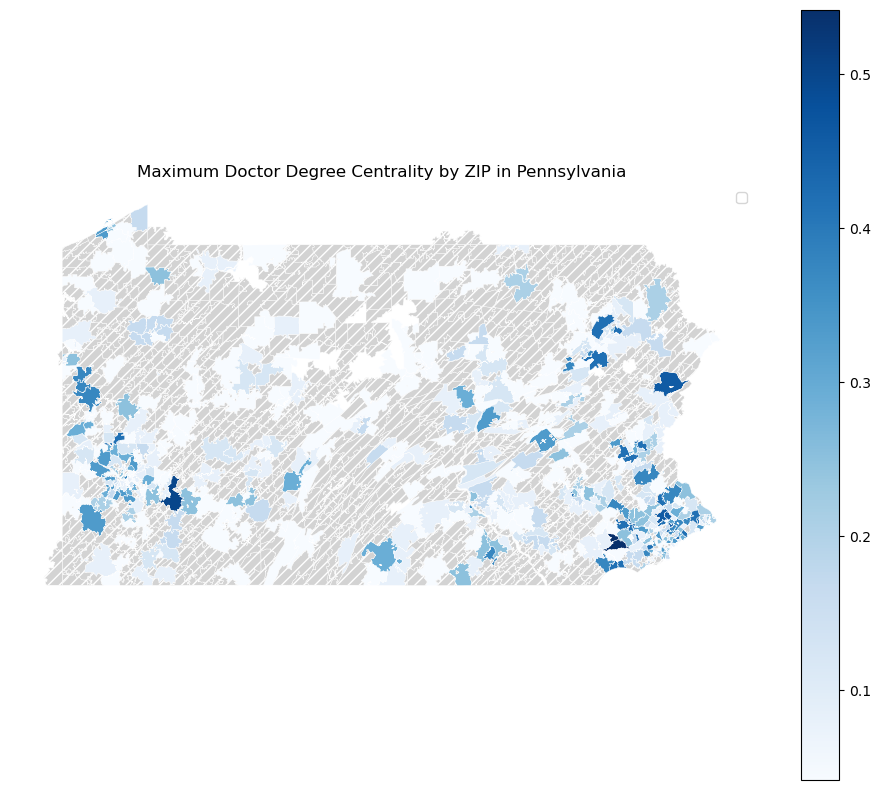

In [250]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load ZIP shapefile
zip_shapes = gpd.read_file("pa_zip_shapefile.shp")
zip_shapes = zip_shapes.rename(columns={"ZCTA5CE": "zip"})
zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)

# Load centrality scores
df_centrality = pd.read_csv("doctor_degree_centrality.csv", dtype=str)
df_centrality["doctor_id"] = df_centrality["doctor_id"].str.split(".").str[0].str.zfill(10)

# Merge with ZIP data (assuming df_zips is already created & cleaned)
df_joined = pd.merge(df_centrality, df_zips, on="doctor_id", how="inner")
df_joined["degree_centrality"] = df_joined["degree_centrality"].astype(float)

# Use MAX instead of average
df_by_zip = df_joined.groupby("zip").agg(
    max_centrality=("degree_centrality", "max"),
    doctor_count=("doctor_id", "count")
).reset_index()

# Merge with spatial shapes
df_by_zip["zip"] = df_by_zip["zip"].astype(str).str.zfill(5)
merged = zip_shapes.merge(df_by_zip, on="zip", how="left")

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

merged.plot(
    column="max_centrality",
    cmap="Blues",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Maximum Doctor Degree Centrality by ZIP in Pennsylvania")
plt.axis("off")
plt.legend()
fig.savefig("doctor_degree_centrality_map.jpg", dpi=300, bbox_inches="tight", format="jpg")
plt.show()



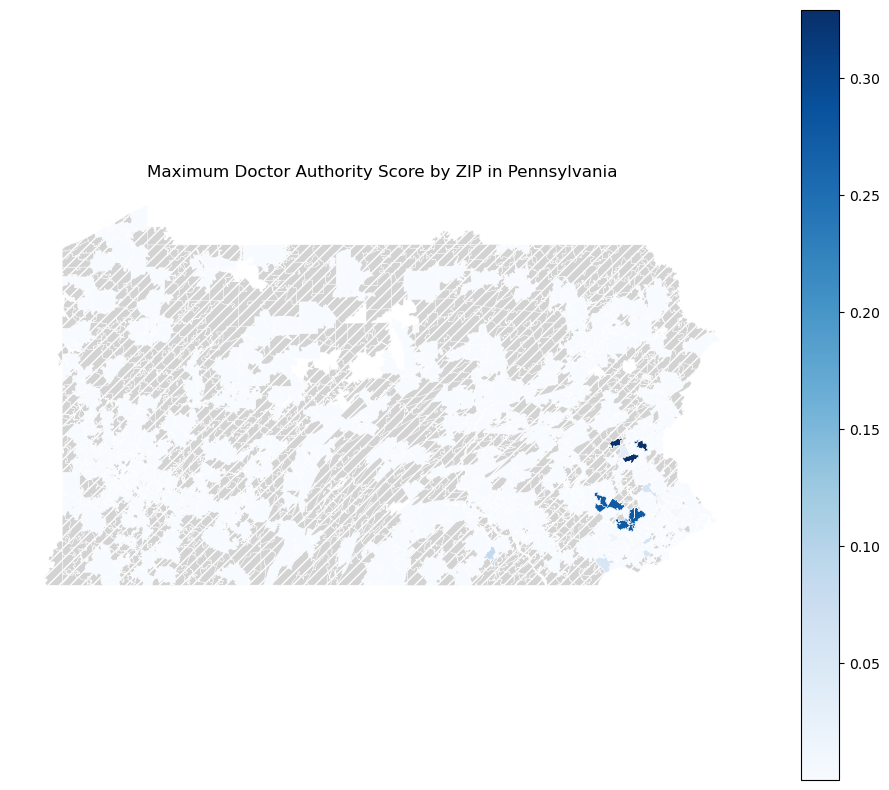

In [251]:

df_authority = pd.read_csv("doctor_authority_scores.csv", dtype={"doctor_id": str})
df_authority["doctor_id"] = df_authority["doctor_id"].str.split(".").str[0].str.zfill(10)
df_authority["authority_score"] = df_authority["authority_score"].astype(float)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str).str.strip().str.zfill(10)
df_joined_auth = pd.merge(df_authority, df_zips, on="doctor_id", how="inner")
df_by_zip_auth = df_joined_auth.groupby("zip").agg(
    max_authority=("authority_score", "max"),
    doctor_count=("doctor_id", "count")
).reset_index()
zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)
df_by_zip_auth["zip"] = df_by_zip_auth["zip"].astype(str).str.zfill(5)
merged_auth = zip_shapes.merge(df_by_zip_auth, on="zip", how="left")
fig, ax = plt.subplots(figsize=(12, 10))
merged_auth.plot(
    column="max_authority",
    cmap="Blues",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Maximum Doctor Authority Score by ZIP in Pennsylvania")
plt.axis("off")

fig.savefig("doctor_simple_authority_map.jpg", dpi=300, bbox_inches="tight", format="jpg")
plt.show()




In [253]:

top_zip_max_auth = df_by_zip_auth.sort_values("max_authority", ascending=False)
print(top_zip_max_auth[["zip", "max_authority", "doctor_count"]].head())

       zip  max_authority  doctor_count
348  18017       0.329150            22
365  18078       0.329150             1
368  18103       0.329150            29
582  19460       0.276301            21
593  19518       0.276301             1


In [254]:
import pandas as pd

max_auth_idx = df_joined_auth.groupby("zip")["authority_score"].idxmax()
top_doctors_by_zip = df_joined_auth.loc[max_auth_idx, ["zip", "doctor_id", "authority_score"]]
top_doctors_by_zip = top_doctors_by_zip.sort_values("authority_score", ascending=False)
df_names = pd.read_csv("generalpaymentspa.csv", dtype=str)
df_names["Covered_Recipient_NPI"] = df_names["Covered_Recipient_NPI"].astype(str).str.strip().str.zfill(10)
top_doctors_by_zip["doctor_id"] = top_doctors_by_zip["doctor_id"].astype(str).str.strip().str.zfill(10)
top_doctors_named = pd.merge(
    top_doctors_by_zip,
    df_names[["Covered_Recipient_NPI", "Covered_Recipient_First_Name", "Covered_Recipient_Last_Name"]],
    left_on="doctor_id",
    right_on="Covered_Recipient_NPI",
    how="left"
).drop_duplicates(subset=["doctor_id", "zip"])
top_doctors_named = top_doctors_named[["zip", "doctor_id", "authority_score", "Covered_Recipient_First_Name", "Covered_Recipient_Last_Name"]]
top_doctors_named = top_doctors_named.sort_values("authority_score", ascending=False)
top_doctors_named.to_csv("top_authority_doctors_by_zip.csv", index=False)


In [45]:
from scipy.sparse.linalg import svds

df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})
companies = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
doctors = df_network["Covered_Recipient_NPI"].unique()
company_to_idx = {name: i for i, name in enumerate(companies)}
doctor_to_idx = {npi: j for j, npi in enumerate(doctors)}
W = np.zeros((len(companies), len(doctors)))
for _, row in df_network.iterrows():
    i = company_to_idx[row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"]]
    j = doctor_to_idx[row["Covered_Recipient_NPI"]]
    W[i, j] = row["Total_Opioid_Payments"]
Dx = np.diag(W.sum(axis=1))
Dy = np.diag(W.sum(axis=0))
Dx_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=1), 1e-10)))
Dy_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=0), 1e-10)))
W_hat = Dx_inv_sqrt @ W @ Dy_inv_sqrt
u, s, vt = svds(W_hat, k=2)
x_hat = u[:, -1]  
y_hat = vt.T[:, -1] 
x = Dx_inv_sqrt @ x_hat
y = Dy_inv_sqrt @ y_hat
cx = np.median(x)
cy = np.median(y)
A = [companies[i] for i in range(len(x)) if x[i] >= cx]
Ac = [companies[i] for i in range(len(x)) if x[i] < cx]
B = [doctors[j] for j in range(len(y)) if y[j] >= cy]
Bc = [doctors[j] for j in range(len(y)) if y[j] < cy]

print("Partition A (pharma):", A[:5])
print("Partition B (doctors):", B[:5])

Partition A (pharma): ['Akrimax Pharmaceuticals, LLC', 'BioDelivery Sciences International, Inc.', 'Daiichi Sankyo Inc.', 'Egalet US Inc', 'INSYS Therapeutics Inc']
Partition B (doctors): ['1194731547.0', '1275505919.0', '1316042591.0', '1336159508.0', '1578561023.0']


In [46]:
partition_A_indices = np.where(x >= cx)[0]
partition_Ac_indices = np.where(x < cx)[0]
partition_A_companies = [companies[i] for i in partition_A_indices]
partition_Ac_companies = [companies[i] for i in partition_Ac_indices]
print("Number of pharma companies in Partition A:", len(partition_A_companies))
print("Number of pharma companies in Partition Aᶜ:", len(partition_Ac_companies))
print("\nPartition A Companies:")
print(partition_A_companies)
print("\nPartition Aᶜ Companies:")
print(partition_Ac_companies)

Number of pharma companies in Partition A: 12
Number of pharma companies in Partition Aᶜ: 12

Partition A Companies:
['Akrimax Pharmaceuticals, LLC', 'BioDelivery Sciences International, Inc.', 'Daiichi Sankyo Inc.', 'Egalet US Inc', 'INSYS Therapeutics Inc', 'Mallinckrodt LLC', 'Mylan Pharmaceuticals Inc.', 'Mylan Specialty L.P.', 'PFIZER INC.', 'Purdue Transdermal Technologies L.P.', 'The Medicines Company', 'Vertical Pharmaceuticals, LLC']

Partition Aᶜ Companies:
['Braeburn Pharmaceuticals, Inc.', 'Collegium Pharmaceutical, Inc.', 'Depomed, Inc.', 'Endo Pharmaceuticals Inc.', 'Fresenius Kabi USA, LLC', 'Indivior Inc.', 'Mission Pharmacal Company', 'Mylan Institutional Inc.', 'Orexo US, Inc.', 'Pernix Therapeutics Holdings, Inc.', 'Purdue Pharma L.P.', 'Sentynl Therapeutics, Inc.']


In [47]:
import numpy as np
import pandas as pd

cy = np.median(y)
partition_B_indices = np.where(y >= cy)[0]
partition_B_doctors = [doctors[j] for j in partition_B_indices]
partition_Bc_indices = np.where(y < cy)[0]
partition_Bc_doctors = [doctors[j] for j in partition_Bc_indices]
print("Number in Partition B:", len(partition_B_doctors))
print("Number in Partition Bᶜ:", len(partition_Bc_doctors))
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})
df_partition_B = df_network[df_network["Covered_Recipient_NPI"].isin(partition_B_doctors)]
payments_summary = df_partition_B.groupby("Covered_Recipient_NPI").agg(
    Total_Received=("Total_Opioid_Payments", "sum"),
    Num_Companies=("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "nunique")
).reset_index()
print(payments_summary.head())

Number in Partition B: 1048
Number in Partition Bᶜ: 978
  Covered_Recipient_NPI  Total_Received  Num_Companies
0          1003022500.0          169.20              3
1          1003120213.0          221.76              2
2          1003143280.0           28.53              1
3          1003171141.0           12.75              1
4          1003296245.0           12.22              1


In [49]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

# Step 1: Load and normalize
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})

df_network["Company_Total"] = df_network.groupby(
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"
)["Total_Opioid_Payments"].transform("sum")

df_network["Normalized_Weight"] = (
    df_network["Total_Opioid_Payments"] / df_network["Company_Total"]
)

# Step 2: Recursive function
def recursive_partition(df_network, min_group_size=6):
    partitions = [{"name": "root", "companies": df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()}]
    final = []

    while partitions:
        part = partitions.pop(0)
        companies = part["companies"]
        if len(companies) <= min_group_size:
            final.append(part)
            continue

        sub_df = df_network[df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].isin(companies)]
        doctors = sub_df["Covered_Recipient_NPI"].unique()

        company_to_idx = {c: i for i, c in enumerate(companies)}
        doctor_to_idx = {d: j for j, d in enumerate(doctors)}

        W = np.zeros((len(companies), len(doctors)))
        for _, row in sub_df.iterrows():
            i = company_to_idx[row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"]]
            j = doctor_to_idx[row["Covered_Recipient_NPI"]]
            W[i, j] = row["Normalized_Weight"]

        Dx_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=1), 1e-10)))
        Dy_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=0), 1e-10)))
        W_hat = Dx_inv_sqrt @ W @ Dy_inv_sqrt

        u, s, vt = svds(W_hat, k=2)
        x_hat = u[:, -1]
        x = Dx_inv_sqrt @ x_hat
        cx = np.median(x)

        A = [companies[i] for i in range(len(x)) if x[i] >= cx]
        Ac = [companies[i] for i in range(len(x)) if x[i] < cx]

        partitions.append({"name": part["name"] + "_A", "companies": A})
        partitions.append({"name": part["name"] + "_Ac", "companies": Ac})

    return final

# Step 3: Run the recursive partitioning
final_partitions = recursive_partition(df_network, min_group_size=6)

# Step 4: Display results
for p in final_partitions:
    print(f"📦 Partition '{p['name']}' — {len(p['companies'])} companies")
    print(p["companies"])
    print()



📦 Partition 'root_A_A' — 6 companies
['Akrimax Pharmaceuticals, LLC', 'Braeburn Pharmaceuticals, Inc.', 'Egalet US Inc', 'Mallinckrodt LLC', 'PFIZER INC.', 'Purdue Transdermal Technologies L.P.']

📦 Partition 'root_A_Ac' — 6 companies
['Indivior Inc.', 'Mylan Pharmaceuticals Inc.', 'Mylan Specialty L.P.', 'Orexo US, Inc.', 'Purdue Pharma L.P.', 'Vertical Pharmaceuticals, LLC']

📦 Partition 'root_Ac_A' — 6 companies
['BioDelivery Sciences International, Inc.', 'Collegium Pharmaceutical, Inc.', 'Depomed, Inc.', 'Endo Pharmaceuticals Inc.', 'Fresenius Kabi USA, LLC', 'Pernix Therapeutics Holdings, Inc.']

📦 Partition 'root_Ac_Ac' — 6 companies
['Daiichi Sankyo Inc.', 'INSYS Therapeutics Inc', 'Mission Pharmacal Company', 'Mylan Institutional Inc.', 'Sentynl Therapeutics, Inc.', 'The Medicines Company']



In [54]:
# Step 1: Build company → cluster mapping
company_to_cluster = {}
for partition in final_partitions:
    for company in partition["companies"]:
        company_to_cluster[company] = partition["name"]

# Step 2: Assign cluster labels to each payment record
df_network["cluster"] = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].map(company_to_cluster)
df_network = df_network.dropna(subset=["cluster"])

# Step 3: Standardize NPIs
df_network["Covered_Recipient_NPI"] = (
    df_network["Covered_Recipient_NPI"]
    .astype(str)
    .str.strip()
    .str.split(".").str[0]
    .str.zfill(10)
)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str).str.strip().str.zfill(10)



# Step 4: Merge ZIP code info into payment data
df_merged = df_network.merge(df_zips, left_on="Covered_Recipient_NPI", right_on="doctor_id", how="left")

# Step 5: Group by ZIP + cluster
df_zip_summary = (
    df_merged.groupby(["zip", "cluster"])["Covered_Recipient_NPI"]
    .nunique()
    .reset_index()
    .rename(columns={"Covered_Recipient_NPI": "doctor_count"})
)

# Step 6: Output or inspect
print(df_zip_summary.head())
# Optional: save
df_zip_summary.to_csv("doctors_by_zip_and_cluster.csv", index=False)



     zip    cluster  doctor_count
0  01510  root_A_Ac             1
1  01522  root_A_Ac             1
2  01801  root_A_Ac             1
3  01801  root_Ac_A             1
4  08002  root_A_Ac             1


In [55]:
# Pick the dominant pharma cluster per ZIP (most doctors)
df_zip_dominant = (
    df_zip_summary.sort_values(["zip", "doctor_count"], ascending=[True, False])
    .drop_duplicates(subset="zip")
)

/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/2723779623.py:31: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


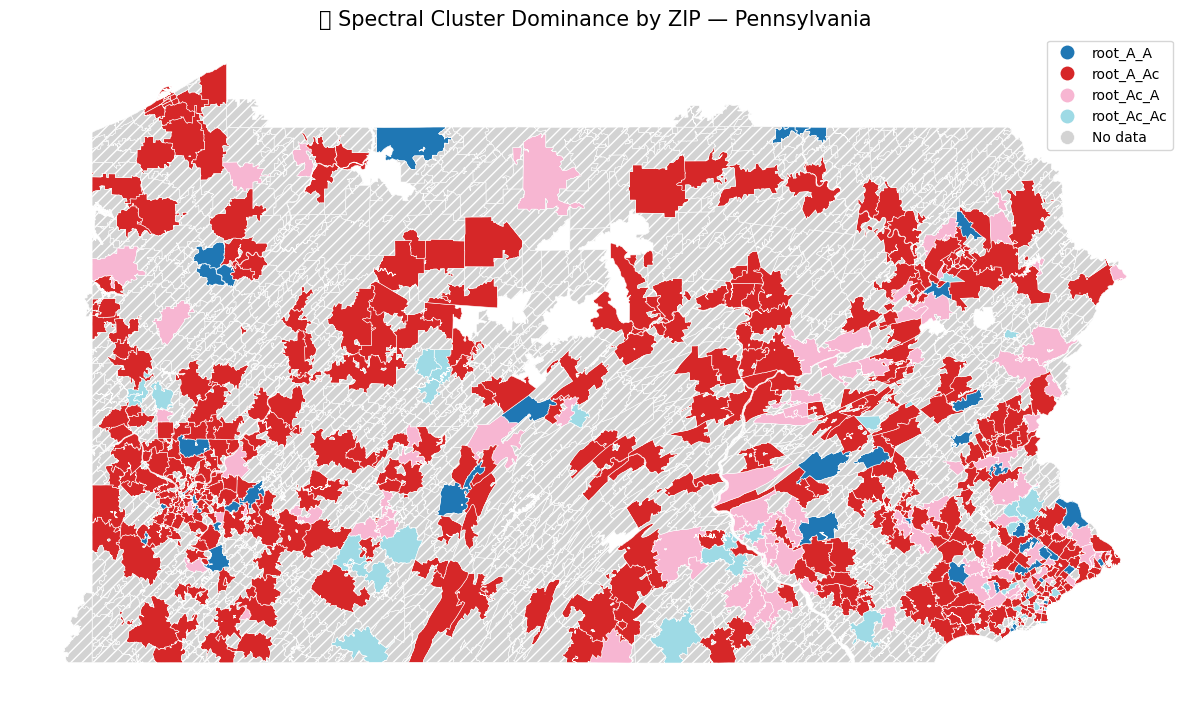

In [56]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Step 1: Make sure ZIP codes are zero-padded strings
zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)
df_zip_dominant["zip"] = df_zip_dominant["zip"].astype(str).str.zfill(5)

# Step 2: Merge shapefile with dominant cluster labels
zip_cluster_map = zip_shapes.merge(df_zip_dominant, on="zip", how="left")

# Step 3: Plot
fig, ax = plt.subplots(figsize=(12, 10))

zip_cluster_map.plot(
    column="cluster",
    cmap="tab20",
    linewidth=0.4,
    edgecolor="white",
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("🧬 Spectral Cluster Dominance by ZIP — Pennsylvania", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()


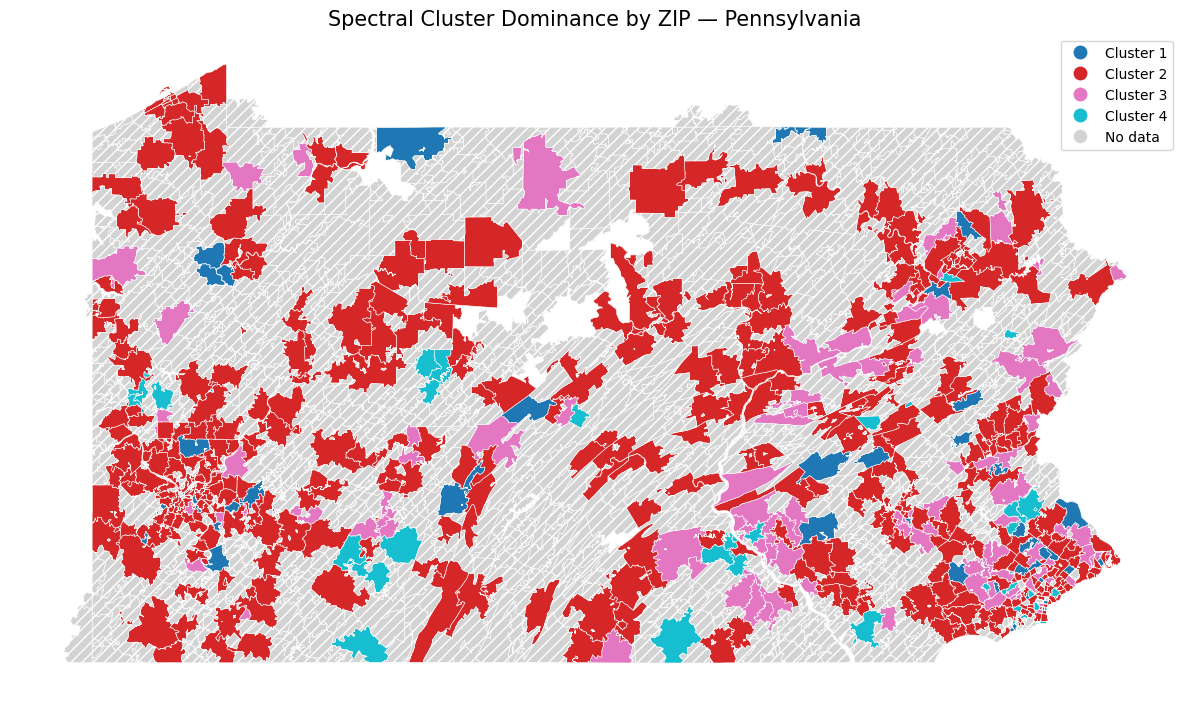

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Map original cluster names to clean ones
cluster_name_map = {
    "root_A_A": "Cluster 1",
    "root_A_Ac": "Cluster 2",
    "root_Ac_A": "Cluster 3",
    "root_Ac_Ac": "Cluster 4"
}

# Step 2: Apply clean names to df_zip_dominant
df_zip_dominant["clean_cluster"] = df_zip_dominant["cluster"].map(cluster_name_map)

# Step 3: Merge for plotting
zip_cluster_map = zip_shapes.merge(df_zip_dominant[["zip", "clean_cluster"]], on="zip", how="left")

# Step 4: Plot map with cleaned legend
fig, ax = plt.subplots(figsize=(12, 10))
zip_cluster_map.plot(
    column="clean_cluster",
    cmap="tab10",
    linewidth=0.4,
    edgecolor="white",
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Spectral Cluster Dominance by ZIP — Pennsylvania", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()


In [59]:
# Step 5: Build table of companies per cluster
cluster_company_table = {
    cluster_name_map.get(partition["name"], partition["name"]): partition["companies"]
    for partition in final_partitions
}

# Step 6: Convert to DataFrame (column per cluster)
cluster_table_df = pd.DataFrame(dict([
    (label, pd.Series(companies)) for label, companies in cluster_company_table.items()
]))

# Optional: Display or save
print(cluster_table_df)
# cluster_table_df.to_csv("cluster_company_table.csv", index=False)


                              Cluster 1                      Cluster 2  \
0          Akrimax Pharmaceuticals, LLC                  Indivior Inc.   
1        Braeburn Pharmaceuticals, Inc.     Mylan Pharmaceuticals Inc.   
2                         Egalet US Inc           Mylan Specialty L.P.   
3                      Mallinckrodt LLC                 Orexo US, Inc.   
4                           PFIZER INC.             Purdue Pharma L.P.   
5  Purdue Transdermal Technologies L.P.  Vertical Pharmaceuticals, LLC   

                                  Cluster 3                   Cluster 4  
0  BioDelivery Sciences International, Inc.         Daiichi Sankyo Inc.  
1            Collegium Pharmaceutical, Inc.      INSYS Therapeutics Inc  
2                             Depomed, Inc.   Mission Pharmacal Company  
3                 Endo Pharmaceuticals Inc.    Mylan Institutional Inc.  
4                   Fresenius Kabi USA, LLC  Sentynl Therapeutics, Inc.  
5        Pernix Therapeutics Holdings

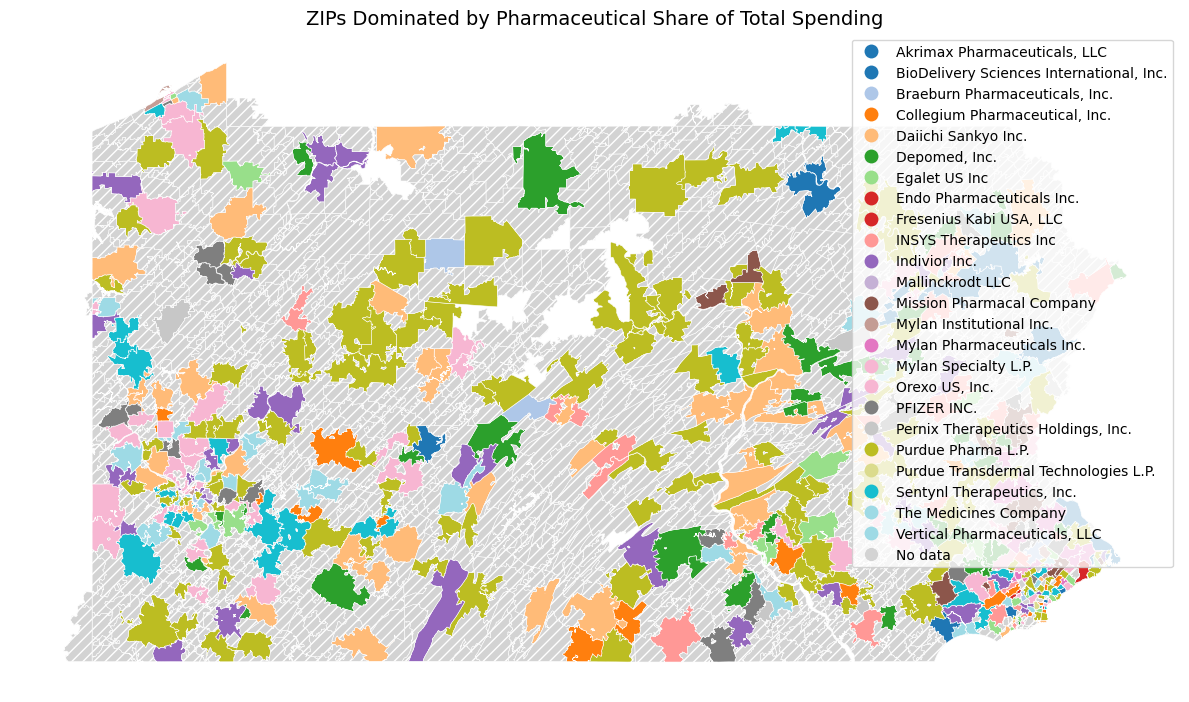

In [60]:
# Step 1: Merge payment data with ZIPs
df_network = df_network.merge(df_zips, left_on="Covered_Recipient_NPI", right_on="doctor_id", how="left")

# Step 2: Total payments per company (normalization denominator)
company_totals = df_network.groupby("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name")["Total_Opioid_Payments"].sum().rename("company_total")
df_network = df_network.merge(company_totals, left_on="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", right_index=True)

# Step 3: Calculate company share per ZIP
df_network["zip_share"] = df_network["Total_Opioid_Payments"] / df_network["company_total"]

# Step 4: Aggregate company share per ZIP
zip_company_share = df_network.groupby(["zip", "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"])["zip_share"].sum().reset_index()

# Step 5: For each ZIP, get company with highest share of their total spending
zip_top_company = zip_company_share.sort_values(["zip", "zip_share"], ascending=[True, False]).drop_duplicates(subset="zip")

# Step 6: Merge with shapefile
zip_top_company["zip"] = zip_top_company["zip"].astype(str).str.zfill(5)
zip_dominance_map = zip_shapes.merge(zip_top_company, on="zip", how="left")

# Step 7: Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
zip_dominance_map.plot(
    column="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name",
    cmap="tab20",
    linewidth=0.4,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("ZIPs Dominated by Pharmaceutical Share of Total Spending", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [62]:
zip_dominance_counts = zip_top_company["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].value_counts()
print(zip_dominance_counts)

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name
Depomed, Inc.                           7
Purdue Pharma L.P.                      5
Akrimax Pharmaceuticals, LLC            4
PFIZER INC.                             4
Mylan Institutional Inc.                4
INSYS Therapeutics Inc                  4
Sentynl Therapeutics, Inc.              2
Pernix Therapeutics Holdings, Inc.      2
Egalet US Inc                           2
Mission Pharmacal Company               2
Braeburn Pharmaceuticals, Inc.          2
Mylan Pharmaceuticals Inc.              2
Collegium Pharmaceutical, Inc.          2
Fresenius Kabi USA, LLC                 2
Endo Pharmaceuticals Inc.               1
Purdue Transdermal Technologies L.P.    1
Mylan Specialty L.P.                    1
Mallinckrodt LLC                        1
Vertical Pharmaceuticals, LLC           1
The Medicines Company                   1
Indivior Inc.                           1
Name: count, dtype: int64


In [63]:
top_zip_targets = zip_company_share.sort_values("zip_share", ascending=False).head(10)
print(top_zip_targets)


        zip Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name  \
317   15221                                   Mallinckrodt LLC              
2221  19104               Purdue Transdermal Technologies L.P.              
990   17055                              The Medicines Company              
256   15212                               Mylan Specialty L.P.              
2008  19041                          Endo Pharmaceuticals Inc.              
1926  19020                            Fresenius Kabi USA, LLC              
2234  19107                            Fresenius Kabi USA, LLC              
2214  19104                          Endo Pharmaceuticals Inc.              
1928  19020                                     Orexo US, Inc.              
1844  19002                     Braeburn Pharmaceuticals, Inc.              

      zip_share  
317    1.000000  
2221   1.000000  
990    0.896666  
256    0.690076  
2008   0.588633  
1926   0.500000  
2234   0.500000  
2214   0

/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1898163768.py:32: UserWarning: Glyph 128138 (\N{PILL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128138 (\N{PILL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


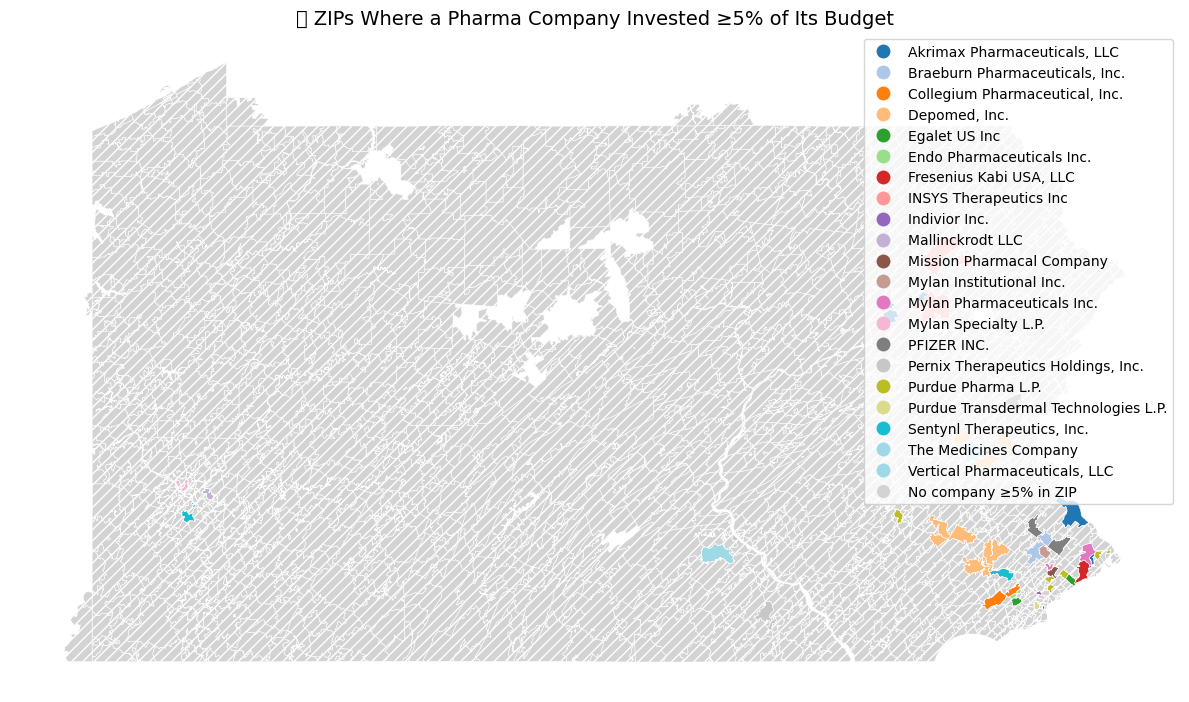

In [61]:
# Keep only ZIP-company pairs where the ZIP received at least 5% of the company’s total state payments
zip_company_share_filtered = zip_company_share[zip_company_share["zip_share"] >= 0.05]

# Now, for each ZIP, find the company with the largest share (among those ≥ 5%)
zip_top_company = zip_company_share_filtered.sort_values(
    ["zip", "zip_share"], ascending=[True, False]
).drop_duplicates(subset="zip")

# Merge with shapefile
zip_top_company["zip"] = zip_top_company["zip"].astype(str).str.zfill(5)
zip_dominance_map = zip_shapes.merge(zip_top_company, on="zip", how="left")

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
zip_dominance_map.plot(
    column="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name",
    cmap="tab20",
    linewidth=0.4,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No company ≥5% in ZIP"
    }
)

plt.title("💊 ZIPs Where a Pharma Company Invested ≥5% of Its Budget", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [67]:
# Step 1: Standardize doctor IDs
df_network["Covered_Recipient_NPI"] = df_network["Covered_Recipient_NPI"].astype(str).str.strip().str.zfill(10)
df_prescribers["Prscrbr_NPI"] = df_prescribers["Prscrbr_NPI"].astype(str).str.strip().str.zfill(10)

# Step 2: Merge in specialty
df_network = df_network.merge(
    df_prescribers[["Prscrbr_NPI", "Prscrbr_Type"]],
    left_on="Covered_Recipient_NPI",
    right_on="Prscrbr_NPI",
    how="left"
)

# Step 3: Aggregate spending by pharma company and specialty
company_specialty = (
    df_network.groupby(["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"])
    ["Total_Opioid_Payments"]
    .sum()
    .reset_index()
)

# Step 4: Normalize within company to get share per specialty
company_totals = company_specialty.groupby("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name")["Total_Opioid_Payments"].sum().rename("company_total")
company_specialty = company_specialty.merge(company_totals, on="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name")
company_specialty["specialty_share"] = company_specialty["Total_Opioid_Payments"] / company_specialty["company_total"]


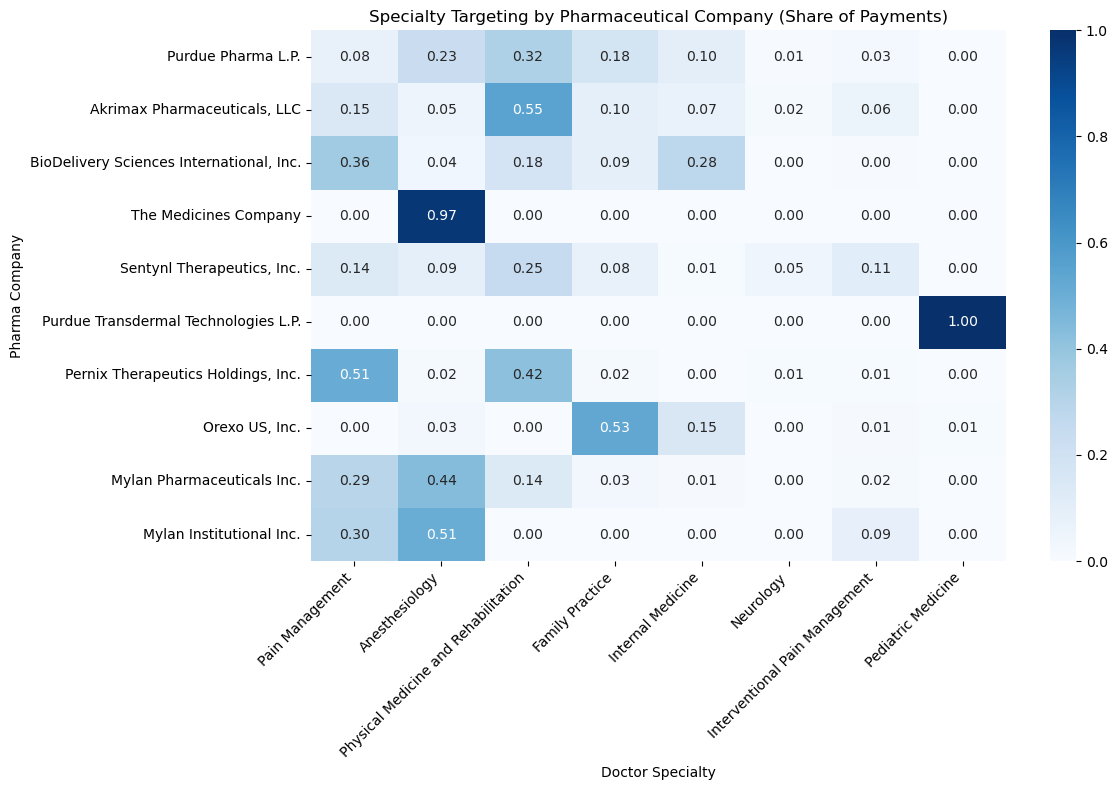

Prscrbr_Type
Pediatric Medicine    1
Name: count, dtype: int64

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step: Pivot table to get heatmap-friendly format
heatmap_data = company_specialty.pivot(
    index="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name",
    columns="Prscrbr_Type",
    values="specialty_share"
).fillna(0)

# Optional: Filter to top N companies or specialties
top_companies = heatmap_data.sum(axis=1).sort_values(ascending=False).head(10).index
top_specialties = heatmap_data.sum(axis=0).sort_values(ascending=False).head(8).index
heatmap_filtered = heatmap_data.loc[top_companies, top_specialties]

# Step: Plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_filtered, annot=True, fmt=".2f", cmap="Blues")
plt.title("Specialty Targeting by Pharmaceutical Company (Share of Payments)")
plt.ylabel("Pharma Company")
plt.xlabel("Doctor Specialty")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_network[
    df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"] == "Purdue Transdermal Technologies L.P."
]["Prscrbr_Type"].value_counts()


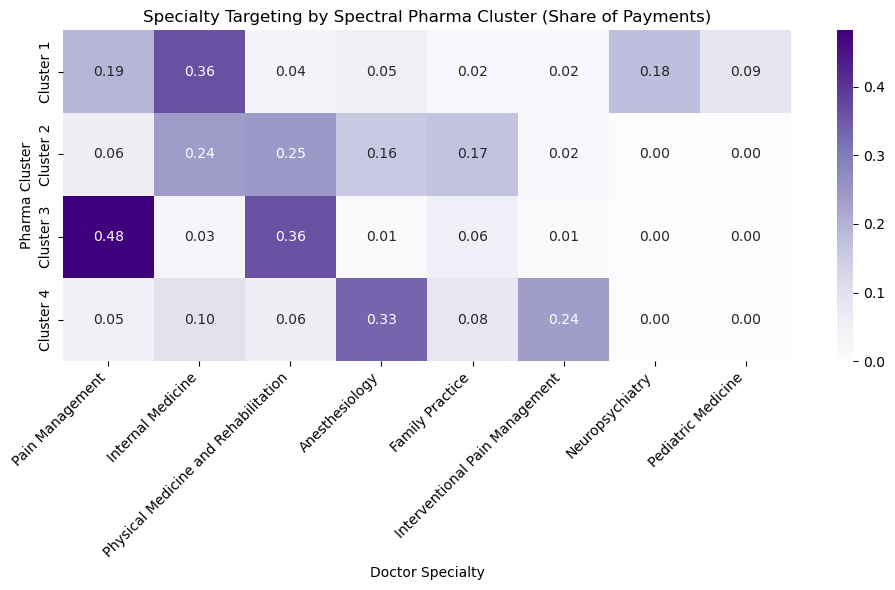

In [84]:
# Map each company to its spectral cluster label (e.g. "Cluster 1")
company_to_cluster = {}
for partition in final_partitions:
    cluster_label = cluster_name_map.get(partition["name"], partition["name"])
    for company in partition["companies"]:
        company_to_cluster[company] = cluster_label

# Assign the cluster to the specialty dataframe
company_specialty["cluster"] = company_specialty["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].map(company_to_cluster)

# Drop any rows where cluster mapping failed
company_specialty = company_specialty.dropna(subset=["cluster"])

# Aggregate total payments per cluster-specialty pair
cluster_specialty = (
    company_specialty.groupby(["cluster", "Prscrbr_Type"])["Total_Opioid_Payments"]
    .sum()
    .reset_index()
)

# Normalize within cluster
cluster_totals = cluster_specialty.groupby("cluster")["Total_Opioid_Payments"].sum().rename("cluster_total")
cluster_specialty = cluster_specialty.merge(cluster_totals, on="cluster")
cluster_specialty["specialty_share"] = cluster_specialty["Total_Opioid_Payments"] / cluster_specialty["cluster_total"]

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot to heatmap format
heatmap_data_cluster = cluster_specialty.pivot(
    index="cluster",
    columns="Prscrbr_Type",
    values="specialty_share"
).fillna(0)

# Optional: filter to top specialties
top_specialties = heatmap_data_cluster.sum(axis=0).sort_values(ascending=False).head(8).index
heatmap_filtered_cluster = heatmap_data_cluster[top_specialties]

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_filtered_cluster, annot=True, fmt=".2f", cmap="Purples")
plt.title("Specialty Targeting by Spectral Pharma Cluster (Share of Payments)")
plt.xlabel("Doctor Specialty")
plt.ylabel("Pharma Cluster")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1281595018.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_specialty_filtered["cluster"] = company_specialty_filtered["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].map(company_to_cluster)


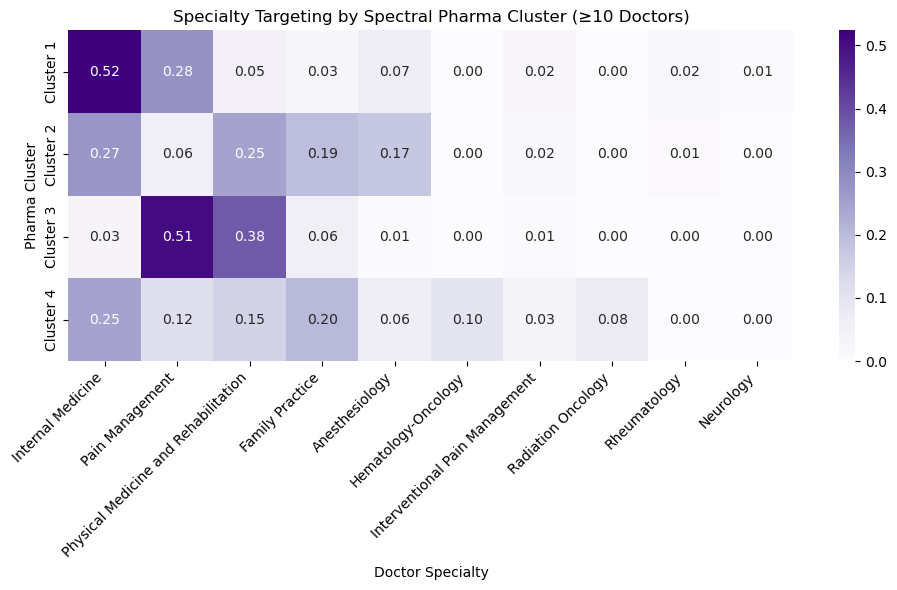

In [88]:
# Fix: drop existing 'doctor_count' column if it exists to avoid merge conflict
if "doctor_count" in company_specialty.columns:
    company_specialty = company_specialty.drop(columns=["doctor_count"])

# Step 1: Count unique doctors per company-specialty
doctor_counts = df_network.groupby(
    ["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"]
)["Covered_Recipient_NPI"].nunique().rename("doctor_count").reset_index()

# Step 2: Merge into company_specialty
company_specialty = company_specialty.merge(
    doctor_counts,
    on=["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"]
)

# Step 3: Filter to specialties with ≥ 3 doctors
company_specialty_filtered = company_specialty[company_specialty["doctor_count"] >= 10]

# Step 4: Assign clusters
company_specialty_filtered["cluster"] = company_specialty_filtered["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].map(company_to_cluster)
company_specialty_filtered = company_specialty_filtered.dropna(subset=["cluster"])

# Step 5: Aggregate total payments by cluster and specialty
cluster_specialty_filtered = (
    company_specialty_filtered
    .groupby(["cluster", "Prscrbr_Type"])["Total_Opioid_Payments"]
    .sum()
    .reset_index()
)

# Step 6: Normalize by cluster total
cluster_totals_filtered = cluster_specialty_filtered.groupby("cluster")["Total_Opioid_Payments"].sum().rename("cluster_total")
cluster_specialty_filtered = cluster_specialty_filtered.merge(cluster_totals_filtered, on="cluster")
cluster_specialty_filtered["specialty_share"] = cluster_specialty_filtered["Total_Opioid_Payments"] / cluster_specialty_filtered["cluster_total"]

# Step 7: Pivot and plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data_filtered = cluster_specialty_filtered.pivot(
    index="cluster",
    columns="Prscrbr_Type",
    values="specialty_share"
).fillna(0)

top_specialties_filtered = heatmap_data_filtered.sum(axis=0).sort_values(ascending=False).head(10).index
heatmap_filtered = heatmap_data_filtered[top_specialties_filtered]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_filtered, annot=True, fmt=".2f", cmap="Purples")
plt.title("Specialty Targeting by Spectral Pharma Cluster (≥10 Doctors)")
plt.xlabel("Doctor Specialty")
plt.ylabel("Pharma Cluster")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


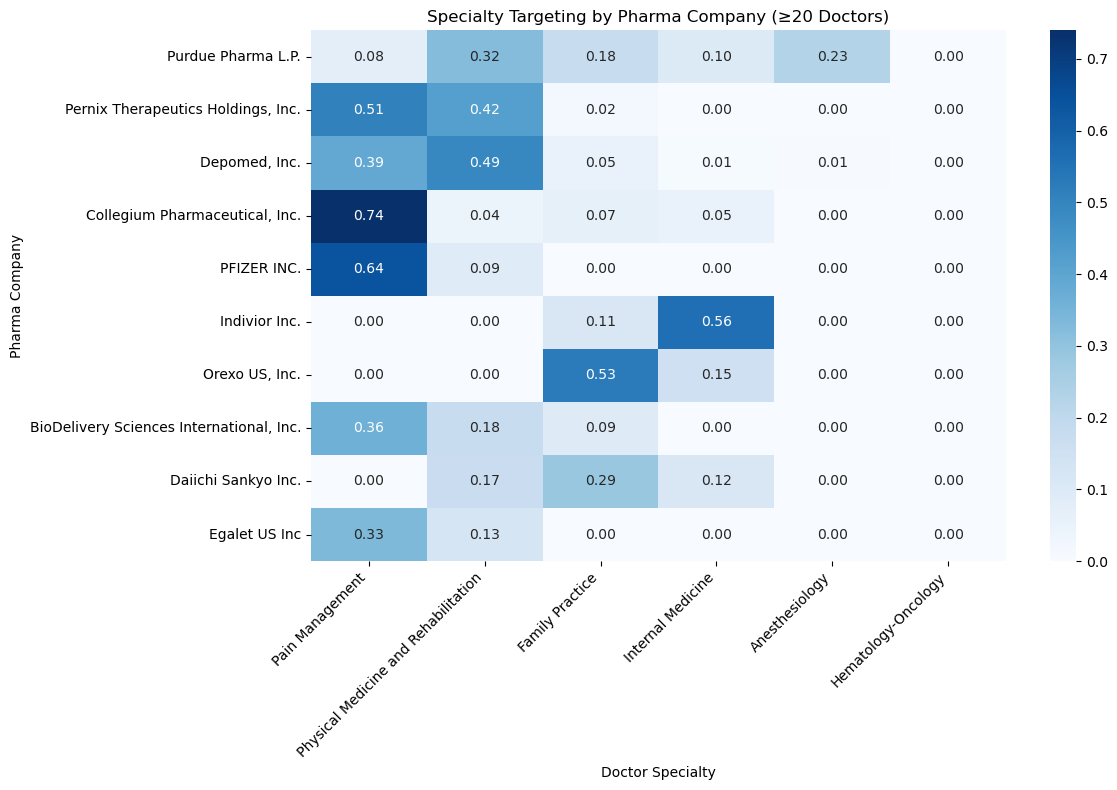

In [92]:
# Step 1: Drop existing 'doctor_count' column if it exists
if "doctor_count" in company_specialty.columns:
    company_specialty = company_specialty.drop(columns=["doctor_count"])

# Step 2: Count doctors per company-specialty
doctor_counts = df_network.groupby(
    ["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"]
)["Covered_Recipient_NPI"].nunique().rename("doctor_count").reset_index()

# Step 3: Merge and filter
company_specialty = company_specialty.merge(
    doctor_counts,
    on=["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"]
)
company_specialty_filtered = company_specialty[company_specialty["doctor_count"] >= 20]

# Step 4: Pivot for heatmap
heatmap_data_company = company_specialty_filtered.pivot(
    index="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name",
    columns="Prscrbr_Type",
    values="specialty_share"
).fillna(0)

# Step 5: Filter to top companies/specialties (optional)
top_companies = heatmap_data_company.sum(axis=1).sort_values(ascending=False).head(10).index
top_specialties = heatmap_data_company.sum(axis=0).sort_values(ascending=False).head(6).index
heatmap_filtered_company = heatmap_data_company.loc[top_companies, top_specialties]

# Step 6: Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_filtered_company, annot=True, fmt=".2f", cmap="Blues")
plt.title("Specialty Targeting by Pharma Company (≥20 Doctors)")
plt.xlabel("Doctor Specialty")
plt.ylabel("Pharma Company")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [257]:
import numpy as np
import pandas as pd
import networkx as nx

# Step 1: Filter companies that pay at least `min_doctors` unique doctors
min_doctors = 0
doctor_counts = df_network.groupby("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name")["Covered_Recipient_NPI"].nunique()
valid_companies = doctor_counts[doctor_counts >= min_doctors].index

# Step 2: Filter original payments to only valid companies
filtered_df = df_network[df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].isin(valid_companies)]

# Step 3: Create bipartite graph
G = nx.Graph()
pharma_nodes = filtered_df["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
doctor_nodes = filtered_df["Covered_Recipient_NPI"].unique()

G.add_nodes_from(pharma_nodes, bipartite=0)
G.add_nodes_from(doctor_nodes, bipartite=1)

# Add edges with weights (e.g., total payment amount)
for _, row in filtered_df.iterrows():
    G.add_edge(row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"], row["Covered_Recipient_NPI"], weight=row.get("Total_Amount_of_Payment_USDollars", 1.0))

# Step 4: Build adjacency matrix B (pharma → doctor)
pharma_nodes = [n for n, d in G.nodes(data=True) if d["bipartite"] == 0]
doctor_nodes = [n for n, d in G.nodes(data=True) if d["bipartite"] == 1]

pharma_idx = {n: i for i, n in enumerate(pharma_nodes)}
doctor_idx = {n: i for i, n in enumerate(doctor_nodes)}

B = np.zeros((len(pharma_nodes), len(doctor_nodes)))

for u, v, data in G.edges(data=True):
    if G.nodes[u]["bipartite"] == 0:  # u = pharma, v = doctor
        i, j = pharma_idx[u], doctor_idx[v]
    else:  # u = doctor, v = pharma
        i, j = pharma_idx[v], doctor_idx[u]
    B[i, j] = data.get("weight", 1.0)

# Step 5: Normalize rows (company → sum to 1)
row_sums = B.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1e-7
B_normalized = B / row_sums

# Step 6: Power iteration for HITS (Hub/Authority)
a = np.ones(len(doctor_nodes))
h = np.ones(len(pharma_nodes))

for _ in range(100):
    a = B_normalized.T @ h
    h = B_normalized @ a
    a /= np.linalg.norm(a)
    h /= np.linalg.norm(h)

# Step 8: Create authority DataFrame
authority_df_norm = pd.DataFrame({
    "doctor_id": doctor_nodes,
    "authority_score_normalized": a
})

hub_df_norm = pd.DataFrame({
    "pharma_company": pharma_nodes,
    "hub_score_normalized": h
})

In [258]:
print(hub_df_norm)

                              pharma_company  hub_score_normalized
0               Akrimax Pharmaceuticals, LLC          6.424017e-06
1   BioDelivery Sciences International, Inc.          4.215802e-06
2             Braeburn Pharmaceuticals, Inc.          1.097561e-06
3             Collegium Pharmaceutical, Inc.          2.667466e-03
4                        Daiichi Sankyo Inc.          4.448397e-06
5                              Depomed, Inc.          4.190715e-06
6                              Egalet US Inc          5.283789e-06
7                  Endo Pharmaceuticals Inc.          2.305515e-08
8                    Fresenius Kabi USA, LLC          7.645267e-01
9                     INSYS Therapeutics Inc          7.130778e-06
10                             Indivior Inc.          6.394425e-07
11                          Mallinckrodt LLC          5.079996e-31
12                 Mission Pharmacal Company          9.393585e-07
13                  Mylan Institutional Inc.          1.100072

In [259]:
top20_doctors = authority_df_norm.sort_values("authority_score_normalized", ascending=False).head(20)
print(top20_doctors)

         doctor_id  authority_score_normalized
252   1.184643e+09                    0.764825
1974  1.598748e+09                    0.644217
304   1.447454e+09                    0.001018
996   1.457438e+09                    0.001009
1985  1.144291e+09                    0.001009
2006  1.922132e+09                    0.001009
1995  1.538361e+09                    0.001009
1982  1.023213e+09                    0.001009
1983  1.053319e+09                    0.001009
1984  1.073502e+09                    0.001009
1992  1.417948e+09                    0.001009
1990  1.275662e+09                    0.001009
1994  1.487645e+09                    0.001009
1986  1.164489e+09                    0.001009
1987  1.205827e+09                    0.001009
1993  1.467423e+09                    0.001009
1988  1.215955e+09                    0.001009
1991  1.356601e+09                    0.001009
2005  1.902857e+09                    0.001009
1996  1.578715e+09                    0.001009


In [220]:
# Convert `doctor_id` in authority_df_norm to integer (removes .0)
authority_df_norm["doctor_id"] = authority_df_norm["doctor_id"].astype(float).astype(int).astype(str)

# Ensure `doctor_id` in df_zips is also a string (if it's not already)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str)

print("Unique doctor_ids in authority_df_norm:", authority_df_norm["doctor_id"].unique()[:10])
print("Unique doctor_ids in df_zips:", df_zips["doctor_id"].unique()[:10])

# Now attempt the merge again
merged_check = authority_df_norm.merge(df_zips, on="doctor_id", how="inner")
print("Merged rows:", len(merged_check))
print(merged_check.head())

Unique doctor_ids in authority_df_norm: ['1003022500' '1013295856' '1023174034' '1023245883' '1033111778'
 '1033177357' '1043292477' '1053351924' '1053434399' '1083614192']
Unique doctor_ids in df_zips: ['1689629438' '1275584807' '1245205608' '1477841468' '1619948544'
 '1083051841' '1760431548' '1326215690' '1801987961' '1669477915']
Merged rows: 3323
    doctor_id  authority_score_normalized    zip
0  1003022500                    0.033806  19090
1  1013295856                    0.025178  15212
2  1013295856                    0.025178  19406
3  1013295856                    0.025178  19103
4  1023174034                    0.027761  19104


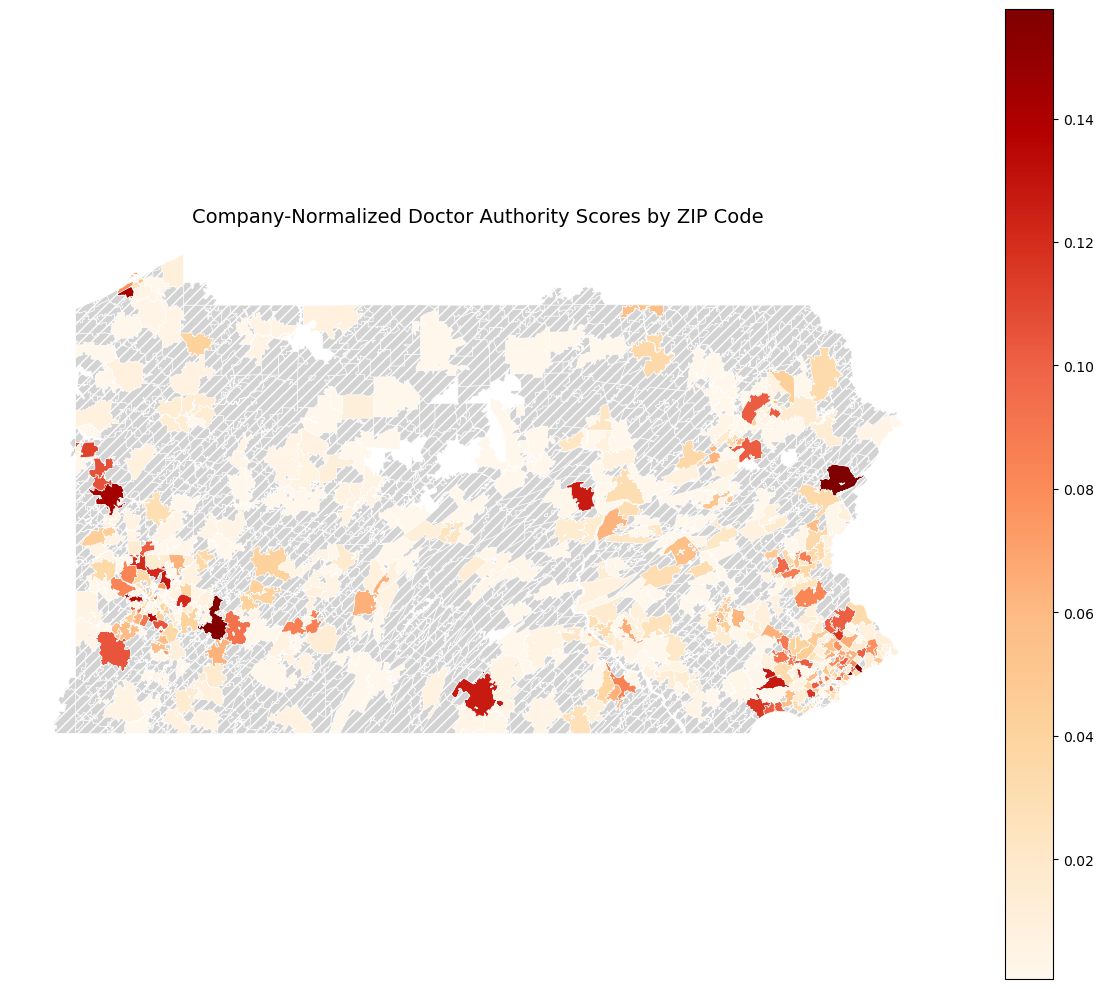

In [221]:
# Step 1: Fix doctor_id formatting
authority_df_norm["doctor_id"] = (
    authority_df_norm["doctor_id"]
    .astype(float)
    .astype(int)
    .astype(str)
    .str.strip()
    .str.zfill(10)
)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str).str.strip().str.zfill(10)

# Step 2: Merge with ZIP codes
authority_zips_norm = authority_df_norm.merge(df_zips, on="doctor_id", how="left")

# Step 3: Aggregate average normalized authority score per ZIP
zip_auth_summary_norm = (
    authority_zips_norm.groupby("zip")["authority_score_normalized"]
    .max()
    .reset_index()
)

# Step 4: Merge with shapefile
zip_auth_summary_norm["zip"] = zip_auth_summary_norm["zip"].astype(str).str.zfill(5)
zip_auth_map_norm = zip_shapes.merge(zip_auth_summary_norm, on="zip", how="left")

# Step 5: Plot
fig, ax = plt.subplots(figsize=(12, 10))
zip_auth_map_norm.plot(
    column="authority_score_normalized",
    cmap="OrRd",
    linewidth=0.4,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Company-Normalized Doctor Authority Scores by ZIP Code", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [210]:
top200_doctors = authority_df_norm.sort_values("authority_score_normalized", ascending=False).head(200)

top200_named = top200_doctors.merge(
    df_payments[
        [
            "Covered_Recipient_NPI",
            "Covered_Recipient_First_Name",
            "Covered_Recipient_Middle_Name",
            "Covered_Recipient_Last_Name",
            "Covered_Recipient_Specialty_1"
        ]
    ].drop_duplicates(subset="Covered_Recipient_NPI", keep="first"),
    left_on="doctor_id",
    right_on="Covered_Recipient_NPI",
    how="left"
)
top200_named.to_csv("top200_doctors_authority_scores.csv", index=False)


In [260]:
from networkx.algorithms import bipartite
import pandas as pd

# Compute clustering coefficient for all pharma companies, including zeros
clust_dict = {n: bipartite.cluster.clustering(G, [n]).get(n, 0.0) for n in pharma_nodes}

# Create sorted DataFrame
clust_df = pd.DataFrame({
    "pharma_company": list(clust_dict.keys()),
    "clustering_coeff": list(clust_dict.values())
}).sort_values("clustering_coeff", ascending=False).reset_index(drop=True)

print(clust_df)

                              pharma_company  clustering_coeff
0         Pernix Therapeutics Holdings, Inc.          0.111663
1                        Daiichi Sankyo Inc.          0.110027
2                                PFIZER INC.          0.107856
3             Collegium Pharmaceutical, Inc.          0.105035
4                              Egalet US Inc          0.101591
5   BioDelivery Sciences International, Inc.          0.100664
6                              Depomed, Inc.          0.083016
7                         Purdue Pharma L.P.          0.074872
8                 Sentynl Therapeutics, Inc.          0.070294
9              Vertical Pharmaceuticals, LLC          0.065831
10                    INSYS Therapeutics Inc          0.050710
11                Mylan Pharmaceuticals Inc.          0.049204
12                            Orexo US, Inc.          0.035354
13                  Mylan Institutional Inc.          0.035001
14                             Indivior Inc.          0

In [233]:
print(len(pharma_nodes))


15
